In [76]:
import numpy as np
import pandas as pd

In [77]:
death_data = pd.read_parquet(
    r"C:\PDS\opioid-2023-kml\00_Data\Deaths_Data\export_data.parquet"
)

In [78]:
death_data.head(10)

,Year,Population,Deaths,FIPS,State
0,2015,66850.0,14.0,17001,IL
1,2012,28288.0,10.0,39001,OH
2,2014,28060.0,10.0,39001,OH
3,2015,27919.0,13.0,39001,OH
4,2003,227022.0,11.0,12001,FL
5,2007,242685.0,17.0,12001,FL
6,2009,246657.0,15.0,12001,FL
7,2010,247624.0,15.0,12001,FL
8,2011,249879.0,14.0,12001,FL
9,2012,251596.0,14.0,12001,FL


In [79]:
death_data["Per Capita Death Rate"] = (
    death_data["Deaths"] / death_data["Population"]
) * 100000

In [80]:
death_data

,Year,Population,Deaths,FIPS,State,Per Capita Death Rate
0,2015,66850.0,14.0,17001,IL,20.942408
1,2012,28288.0,10.0,39001,OH,35.350679
2,2014,28060.0,10.0,39001,OH,35.637919
3,2015,27919.0,13.0,39001,OH,46.563272
4,2003,227022.0,11.0,12001,FL,4.845345
...,...,...,...,...,...,...
12436,2015,906.0,0.0,48393,TX,0.000000
12437,2015,3191.0,0.0,48413,TX,0.000000
12438,2015,1330.0,0.0,48431,TX,0.000000
12439,2015,863.0,0.0,48443,TX,0.000000


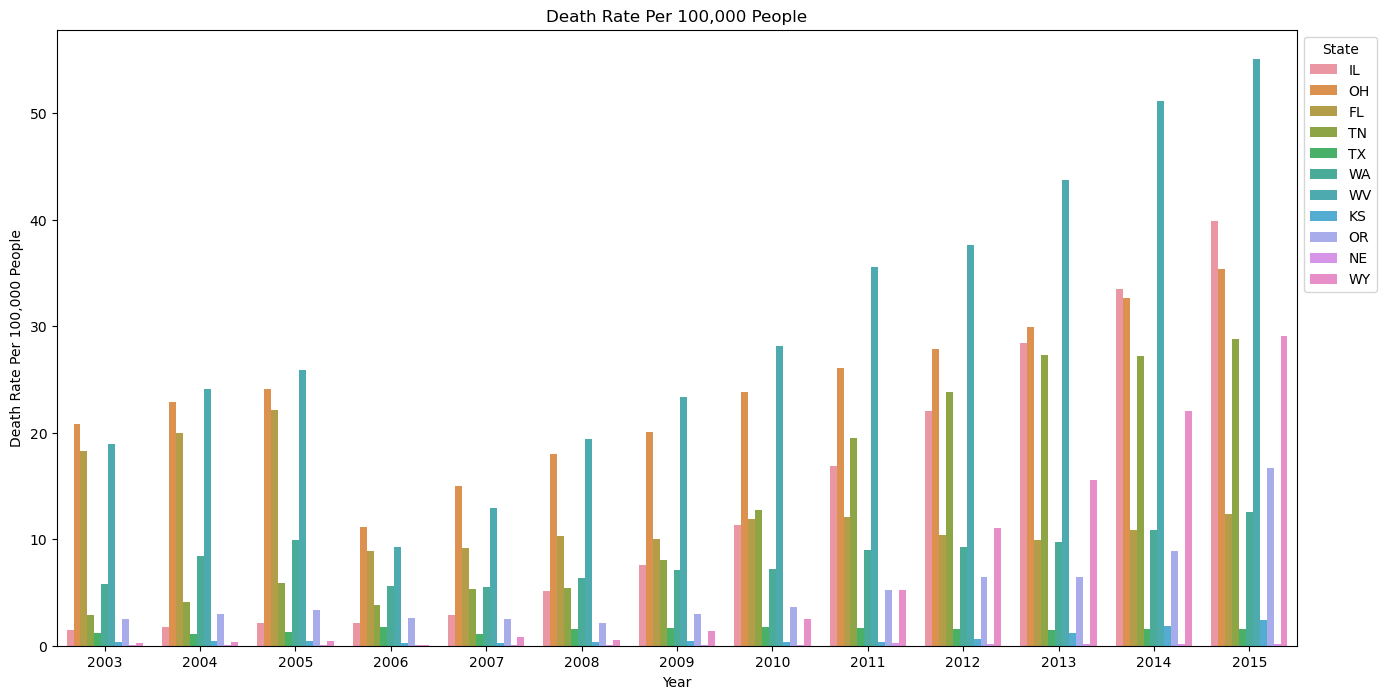

In [81]:
import warnings

# Simplest way: Filter all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.barplot(x="Year", y="Per Capita Death Rate", hue="State", data=death_data, ci=None)
plt.xlabel("Year")
plt.ylabel("Death Rate Per 100,000 People")
plt.title("Death Rate Per 100,000 People")
plt.legend(title="State", bbox_to_anchor=(1, 1))
plt.show()

In [82]:
import statsmodels.formula.api as smf
import altair as alt

In [83]:
def get_reg_fit(data, year_start, year_end, color, yvar, xvar, legend, alpha=0.05):
    colour = color
    years = list(np.arange(year_start, year_end, 1))

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"Per_Capita_Death_Rate ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    predictions["Treat"] = f"{legend}"
    reg = (
        alt.Chart(predictions)
        .mark_line()
        .encode(
            x=xvar,
            y=alt.Y(yvar),
            color=alt.value(f"{colour}"),
            opacity=alt.Opacity("Treat", legend=alt.Legend(title="Legend")),
        )
    )
    ci = (
        alt.Chart(predictions)
        .mark_errorband()
        .encode(
            alt.X(f"{xvar}:Q", axis=alt.Axis(format=".0f", values=years)),
            y=alt.Y(
                "ci_low",
                title="Opioid Shipments per Capita in Milligrams (MME)",
                scale=alt.Scale(zero=False),
            ),
            y2="ci_high",
            color=alt.value(f"{color}"),
        )
    )

    chart = ci + reg
    return predictions, chart

In [84]:
def plotting_chart(
    policy_year, year_start, year_end, color, data, yvar, xvar, legend, alpha=0.05
):
    pl_year = policy_year
    pol_year = []
    pol_year.append(int(pl_year))
    years = list(np.arange(year_start, year_end, 1))

    # Plotting chart
    fit, reg_chart = get_reg_fit(
        color=color,
        data=data,
        yvar=yvar,
        xvar=xvar,
        legend=legend,
        alpha=alpha,
        year_start=year_start,
        year_end=year_end,
    )
    policy = pd.DataFrame({"Year": pol_year})
    rule = (
        alt.Chart(policy)
        .mark_rule(color="black")
        .encode(alt.X("Year:Q", title="Year", axis=alt.Axis(values=years)))
    )
    return (reg_chart + rule).properties(width=800, height=500)

In [85]:
death_data

,Year,Population,Deaths,FIPS,State,Per Capita Death Rate
0,2015,66850.0,14.0,17001,IL,20.942408
1,2012,28288.0,10.0,39001,OH,35.350679
2,2014,28060.0,10.0,39001,OH,35.637919
3,2015,27919.0,13.0,39001,OH,46.563272
4,2003,227022.0,11.0,12001,FL,4.845345
...,...,...,...,...,...,...
12436,2015,906.0,0.0,48393,TX,0.000000
12437,2015,3191.0,0.0,48413,TX,0.000000
12438,2015,1330.0,0.0,48431,TX,0.000000
12439,2015,863.0,0.0,48443,TX,0.000000


In [86]:
death_data = death_data.rename(
    columns={"Per Capita Death Rate": "Per_Capita_Death_Rate"}
)

In [87]:
washington = death_data[death_data["State"] == "WA"]

In [88]:
washington

,Year,Population,Deaths,FIPS,State,Per_Capita_Death_Rate
68,2003,153596.0,10.0,53005,WA,6.510586
69,2004,155689.0,12.0,53005,WA,7.707674
70,2005,157726.0,13.0,53005,WA,8.242141
71,2006,159564.0,16.0,53005,WA,10.027324
72,2007,161669.0,17.0,53005,WA,10.515312
...,...,...,...,...,...,...
11101,2005,10303.0,1.0,53059,WA,9.705911
11102,2005,41612.0,4.0,53065,WA,9.612612
11103,2005,3824.0,0.0,53069,WA,0.000000
11104,2005,56569.0,6.0,53071,WA,10.606516


In [89]:
was_ctrl_states = death_data[
    (death_data["State"] == "OR")
    | (death_data["State"] == "IL")
    | (death_data["State"] == "OH")
]

In [91]:
treatment_state = washington[["Year", "Per_Capita_Death_Rate"]]
ctrl_states = was_ctrl_states[["Year", "Per_Capita_Death_Rate"]]

In [92]:
pre_years = [2009, 2010, 2011]
pre_TreatmentState = washington[washington["Year"].isin(pre_years)]
pre_ctrl = was_ctrl_states[was_ctrl_states["Year"].isin(pre_years)]
post_years = [2012, 2013, 2014]
post_TreatmentState = washington[washington["Year"].isin(post_years)]
post_ctrl = was_ctrl_states[was_ctrl_states["Year"].isin(post_years)]

In [93]:
pre_FL_plot = plotting_chart(
    2012,
    2009,
    2015,
    "#063970",
    pre_TreatmentState,
    "Per_Capita_Death_Rate",
    "Year",
    "Washington",
    alpha=0.05,
)
post_FL_plot = plotting_chart(
    2012,
    2009,
    2015,
    "#063970",
    post_TreatmentState,
    "Per_Capita_Death_Rate",
    "Year",
    "Washington",
    alpha=0.05,
)

In [94]:
pre_post_final = pre_FL_plot + post_FL_plot
pre_post_final.properties(title="Pre-post analysis for Washington")

alt.LayerChart(...)

In [ ]:
pre_crtl_plot = plotting_chart(
    2012,
    2009,
    2015,
    "#873e23",
    pre_crtl,
    "per_capita_MME_mg",
    "TransactionYear",
    "Control States - OR, IL, WY",
    alpha=0.05,
)
post_crtl_plot = plotting_chart(
    2012,
    2009,
    2015,
    "#873e23",
    post_crtl,
    "per_capita_MME_mg",
    "TransactionYear",
    "Control States - OR, IL, WY",
    alpha=0.05,
)

In [ ]:
post = [2007, 2008, 2009]
pre = [2006, 2005, 2004]

# Filter the DataFrame for the specified years and states
TX_KS = filtered_dfs_by_state[
    (
        (filtered_dfs_by_state["Year"].isin(pre))
        & (filtered_dfs_by_state["State"].isin(["TX", "KS"]))
    )
    | (
        (filtered_dfs_by_state["Year"].isin(post))
        & (filtered_dfs_by_state["State"].isin(["TX", "KS"]))
    )
]

# Display the result DataFrame
TX_KS

,Year,FIPS,Deaths,State,County_FIPS,Population
27,2004,48001,11.0,TX,1,56245.0
93,2004,48029,168.0,TX,29,1500919.0
136,2004,48039,19.0,TX,39,268051.0
216,2004,48061,16.0,TX,61,366299.0
383,2004,48085,40.0,TX,85,617802.0
...,...,...,...,...,...,...
7382,2009,20175,NaN,KS,175,22729.0
7389,2009,20191,NaN,KS,191,24160.0
7390,2009,20193,NaN,KS,193,7753.0
7392,2009,20197,NaN,KS,197,7059.0


In [ ]:
missing_data_TX_KS = (
    TX_KS[TX_KS["Deaths"].isna()]
    .groupby(["Year", "State"])
    .size()
    .reset_index(name="MissingCount")
)
print(missing_data_TX_KS["MissingCount"].sum())
missing_data_TX_KS

819


,Year,State,MissingCount
0,2004,KS,49
1,2004,TX,92
2,2005,KS,49
3,2005,TX,90
4,2006,KS,50
5,2006,TX,86
6,2007,KS,50
7,2007,TX,89
8,2008,KS,49
9,2008,TX,83


In [ ]:
TX_KS_cleaned = TX_KS.dropna(subset=["Deaths"])

# Display the sum of missing counts and the DataFrame after dropping NaN values
print(f"Sum of missing counts: {missing_data_TX_KS['MissingCount'].sum()}")
TX_KS_cleaned

Sum of missing counts: 819


,Year,FIPS,Deaths,State,County_FIPS,Population
27,2004,48001,11.0,TX,1,56245.0
93,2004,48029,168.0,TX,29,1500919.0
136,2004,48039,19.0,TX,39,268051.0
216,2004,48061,16.0,TX,61,366299.0
383,2004,48085,40.0,TX,85,617802.0
...,...,...,...,...,...,...
2305,2008,20209,15.0,KS,209,155092.0
941,2009,20091,37.0,KS,91,539396.0
1847,2009,20173,67.0,KS,173,495006.0
1882,2009,20177,24.0,KS,177,176786.0


In [ ]:
post_fl = [2010, 2011, 2012]
pre_fl = [2009, 2008, 2007]

# Filter the DataFrame for the specified years and states
FL_WV = filtered_dfs_by_state[
    (
        (filtered_dfs_by_state["Year"].isin(pre_fl))
        & (filtered_dfs_by_state["State"].isin(["FL", "WV"]))
    )
    | (
        (filtered_dfs_by_state["Year"].isin(post_fl))
        & (filtered_dfs_by_state["State"].isin(["FL", "WV"]))
    )
]

# Display the result DataFrame
FL_WV

,Year,FIPS,Deaths,State,County_FIPS,Population
5,2007,12001,17.0,FL,1,242685.0
46,2007,12005,30.0,FL,5,165345.0
157,2007,12009,104.0,FL,9,539719.0
172,2007,12011,282.0,FL,11,1720825.0
251,2007,12015,17.0,FL,15,159742.0
...,...,...,...,...,...,...
10196,2012,54061,NaN,WV,61,101009.0
10203,2012,54077,NaN,WV,77,33905.0
10204,2012,54079,NaN,WV,79,56448.0
10205,2012,54083,NaN,WV,83,29388.0


In [ ]:
missing_data_FL_WV = (
    FL_WV[FL_WV["Deaths"].isna()]
    .groupby(["Year", "State"])
    .size()
    .reset_index(name="MissingCount")
)
print(missing_data_FL_WV["MissingCount"].sum())
missing_data_FL_WV

99


,Year,State,MissingCount
0,2007,FL,1
1,2007,WV,13
2,2008,FL,3
3,2008,WV,15
4,2009,FL,2
5,2009,WV,23
6,2010,FL,2
7,2010,WV,14
8,2011,FL,1
9,2011,WV,11


> There are very FEW missing data just going to drop for NOW

In [ ]:
FL_WV_cleaned = FL_WV.dropna(subset=["Deaths"])

# Display the sum of missing counts and the DataFrame after dropping NaN values
print(f"Sum of missing counts: {missing_data_FL_WV['MissingCount'].sum()}")
FL_WV_cleaned

Sum of missing counts: 99


,Year,FIPS,Deaths,State,County_FIPS,Population
5,2007,12001,17.0,FL,1,242685.0
46,2007,12005,30.0,FL,5,165345.0
157,2007,12009,104.0,FL,9,539719.0
172,2007,12011,282.0,FL,11,1720825.0
251,2007,12015,17.0,FL,15,159742.0
...,...,...,...,...,...,...
1436,2012,54059,18.0,WV,59,26193.0
1521,2012,54067,11.0,WV,67,26255.0
1725,2012,54081,54.0,WV,81,79284.0
2190,2012,54099,10.0,WV,99,41933.0


> Each comparison has 200-300 observations for all years needed for each comparison. This is good. We will need to look into normalizing/filling in missing data. 

In [ ]:
WA_OR_cleaned["DeathRate"] = WA_OR_cleaned["Deaths"] / WA_OR_cleaned["Population"]

c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\M

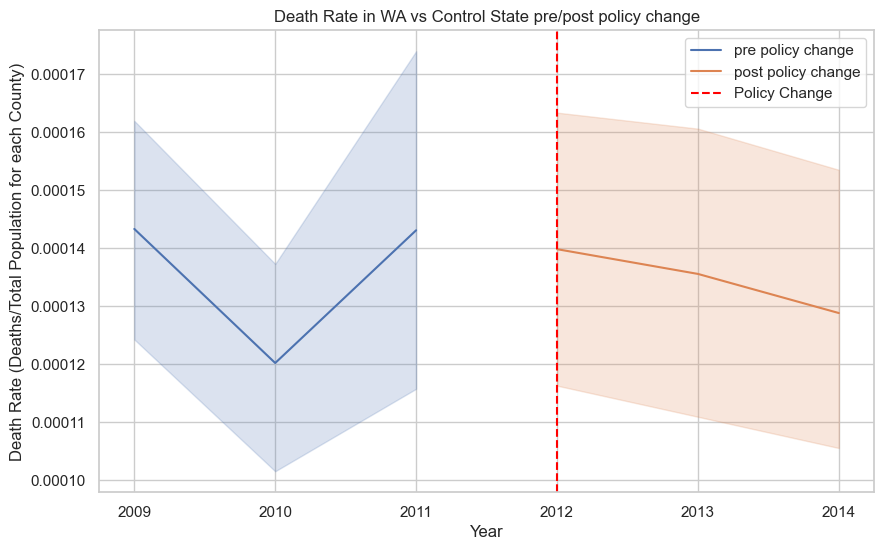

In [ ]:
wa = WA_OR_cleaned[WA_OR_cleaned["State"] == "WA"]
pre_wa_graph = wa[wa["Year"].isin(pre_years)]
post_wa_graph = wa[wa["Year"].isin(post_years)]

# plot pre_fl and post_fl in one graph
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=pre_wa_graph, x="Year", y="DeathRate", label="pre policy change")
sns.lineplot(data=post_wa_graph, x="Year", y="DeathRate", label="post policy change")


plt.axvline(x=2012, color="red", linestyle="--", label="Policy Change")

plt.xlabel("Year")
plt.ylabel("Death Rate (Deaths/Total Population for each County)")
plt.title("Death Rate in WA vs Control State pre/post policy change")
plt.legend()

plt.show()

In [ ]:
FL_WV_cleaned["DeathRate"] = FL_WV_cleaned["Deaths"] / FL_WV_cleaned["Population"]

c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\M

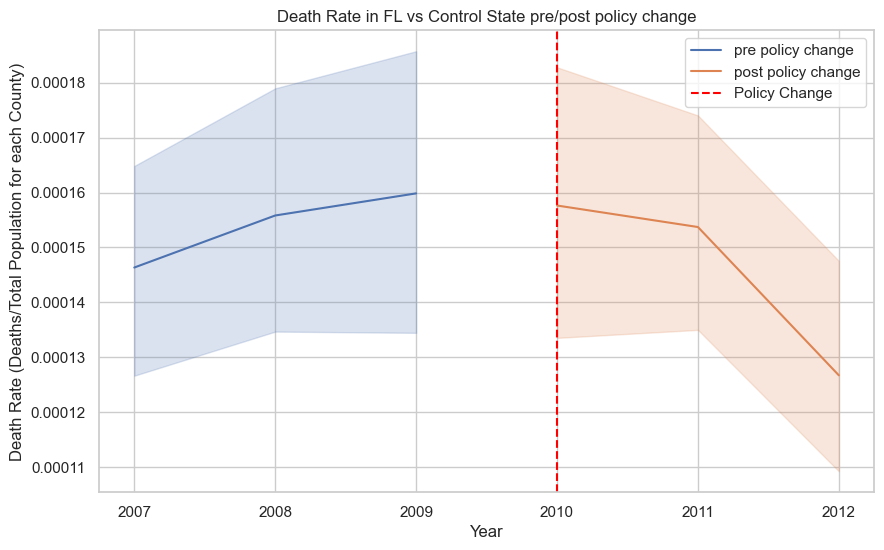

In [ ]:
fl = FL_WV_cleaned[FL_WV_cleaned["State"] == "FL"]
pre_fl_graph = fl[fl["Year"].isin(pre_fl)]
post_fl_graph = fl[fl["Year"].isin(post_fl)]

# plot pre_fl and post_fl in one graph
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=pre_fl_graph, x="Year", y="DeathRate", label="pre policy change")
sns.lineplot(data=post_fl_graph, x="Year", y="DeathRate", label="post policy change")

wv = FL_WV_cleaned[FL_WV_cleaned["State"] == "WV"]
pre_wv_graph = wv[wv["Year"].isin(pre_fl)]
post_wv_graph = wv[wv["Year"].isin(post_fl)]

# sns.lineplot(data=pre_wv_graph, x="Year", y="DeathRate", label="control pre")
# sns.lineplot(data=post_wv_graph, x="Year", y="DeathRate", label="control post")
plt.axvline(x=2010, color="red", linestyle="--", label="Policy Change")

plt.xlabel("Year")
plt.ylabel("Death Rate (Deaths/Total Population for each County)")
plt.title("Death Rate in FL vs Control State pre/post policy change")
plt.legend()

plt.show()

In [ ]:
TX_KS_cleaned["DeathRate"] = TX_KS_cleaned["Deaths"] / TX_KS_cleaned["Population"]

c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\M

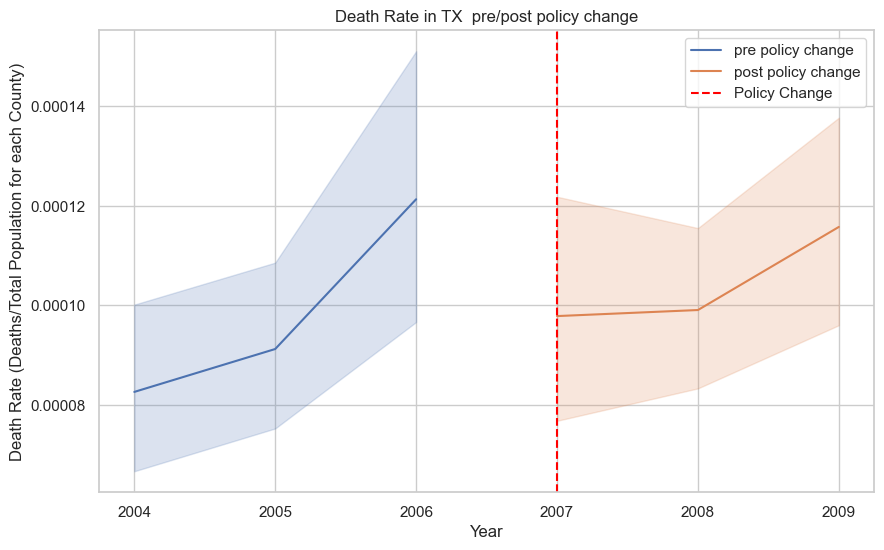

In [ ]:
tx = TX_KS_cleaned[TX_KS_cleaned["State"] == "TX"]
pre_tx_graph = tx[tx["Year"].isin(pre)]
post_tx_graph = tx[tx["Year"].isin(post)]

# plot pre_fl and post_fl in one graph
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=pre_tx_graph, x="Year", y="DeathRate", label="pre policy change")
sns.lineplot(data=post_tx_graph, x="Year", y="DeathRate", label="post policy change")

ks = TX_KS_cleaned[TX_KS_cleaned["State"] == "KS"]
pre_ks_graph = ks[ks["Year"].isin(pre)]
post_ks_graph = ks[ks["Year"].isin(post)]

# sns.lineplot(data=pre_ks_graph, x="Year", y="DeathRate", label="control pre")
# sns.lineplot(data=post_ks_graph, x="Year", y="DeathRate", label="control post")
plt.axvline(x=2007, color="red", linestyle="--", label="Policy Change")

plt.xlabel("Year")
plt.ylabel("Death Rate (Deaths/Total Population for each County)")
plt.title("Death Rate in TX  pre/post policy change")
plt.legend()

plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

wa_plus_ref = WA_OR_cleaned[WA_OR_cleaned["State"].isin(["OR", "WA"])]
wa_plus_ref = wa_plus_ref[
    wa_plus_ref["Year"].isin([2009, 2010, 2011, 2012, 2013, 2014])
]
# Create indicators for the post-policy change period and treatment state
wa_plus_ref["PostPolicy"] = (wa_plus_ref["Year"] >= 2012).astype(int)
wa_plus_ref["Treated"] = (wa_plus_ref["State"] == "WA").astype(int)

# Create interaction terms
wa_plus_ref["PostPolicy_Treated"] = wa_plus_ref["PostPolicy"] * wa_plus_ref["Treated"]
wa_plus_ref["Year_PostPolicy"] = wa_plus_ref["Year"] * wa_plus_ref["PostPolicy"]
wa_plus_ref["Year_PostPolicy_Treated"] = (
    wa_plus_ref["Year"] * wa_plus_ref["PostPolicy"] * wa_plus_ref["Treated"]
)

# Define the model
model = sm.OLS(
    wa_plus_ref["DeathRate"],
    sm.add_constant(
        wa_plus_ref[
            [
                "PostPolicy",
                "Treated",
                "PostPolicy_Treated",
                "Year",
                "Year_PostPolicy",
                "Year_PostPolicy_Treated",
            ]
        ]
    ),
)

# Fit the model
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              DeathRate   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7964
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.574
Time:                        17:30:48   Log-Likelihood:                 1195.1
No. Observations:                 140   AIC:                            -2376.
Df Residuals:                     133   BIC:                            -2356.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\M

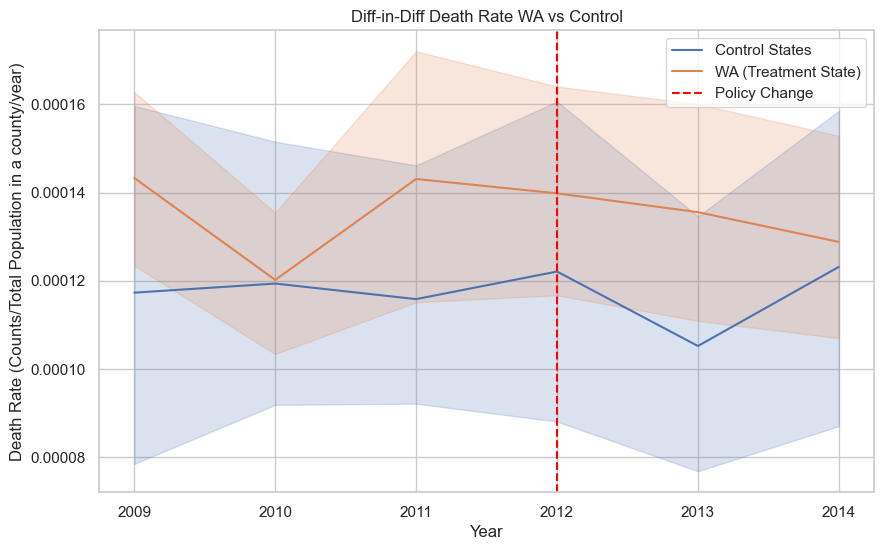

In [ ]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the results
sns.set(style="whitegrid")
# Separate the data for control (non-'WA') and treatment ('WA')
df_control = wa_plus_ref[wa_plus_ref["Treated"] == 0]
df_treatment = wa_plus_ref[wa_plus_ref["Treated"] == 1]
# Plot the trends
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="DeathRate", data=df_control, label="Control States")
sns.lineplot(x="Year", y="DeathRate", data=df_treatment, label="WA (Treatment State)")
plt.title("Diff-in-Diff Death Rate WA vs Control")
plt.axvline(x=2012, color="red", linestyle="--", label="Policy Change")
plt.xlabel("Year")
plt.ylabel("Death Rate (Counts/Total Population in a county/year)")
plt.legend()

# FLORIDA

In [ ]:
fl_diff_diff = FL_WV_cleaned[FL_WV_cleaned["State"].isin(["FL", "WV"])]
fl_diff_diff = fl_diff_diff[
    fl_diff_diff["Year"].isin([2010, 2011, 2012, 2009, 2008, 2007])
]
# Create indicators for the post-policy change period and treatment state
fl_diff_diff["PostPolicy"] = (fl_diff_diff["Year"] >= 2010).astype(int)
fl_diff_diff["Treated"] = (fl_diff_diff["State"] == "FL").astype(int)

# Create interaction terms
fl_diff_diff["PostPolicy_Treated"] = (
    fl_diff_diff["PostPolicy"] * fl_diff_diff["Treated"]
)
fl_diff_diff["Year_PostPolicy"] = fl_diff_diff["Year"] * fl_diff_diff["PostPolicy"]
fl_diff_diff["Year_PostPolicy_Treated"] = (
    fl_diff_diff["Year"] * fl_diff_diff["PostPolicy"] * fl_diff_diff["Treated"]
)

# Define the model
model = sm.OLS(
    fl_diff_diff["DeathRate"],
    sm.add_constant(
        fl_diff_diff[
            [
                "PostPolicy",
                "Treated",
                "PostPolicy_Treated",
                "Year",
                "Year_PostPolicy",
                "Year_PostPolicy_Treated",
            ]
        ]
    ),
)

# Fit the model
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              DeathRate   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     39.77
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           5.76e-34
Time:                        17:30:50   Log-Likelihood:                 2018.3
No. Observations:                 261   AIC:                            -4023.
Df Residuals:                     254   BIC:                            -3998.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\M

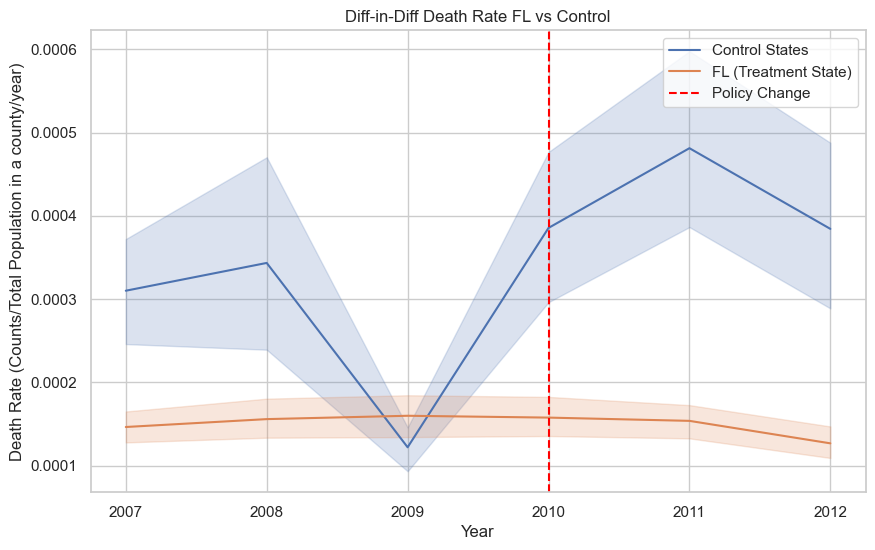

In [ ]:
sns.set(style="whitegrid")

df_control1 = fl_diff_diff[fl_diff_diff["Treated"] == 0]
df_treatment1 = fl_diff_diff[fl_diff_diff["Treated"] == 1]
# Plot the trends
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="DeathRate", data=df_control1, label="Control States")
sns.lineplot(x="Year", y="DeathRate", data=df_treatment1, label="FL (Treatment State)")
plt.axvline(x=2010, color="red", linestyle="--", label="Policy Change")
plt.title("Diff-in-Diff Death Rate FL vs Control")

plt.xlabel("Year")
plt.ylabel("Death Rate (Counts/Total Population in a county/year)")
plt.legend()

In [ ]:
tx_diff_diff = TX_KS_cleaned[TX_KS_cleaned["State"].isin(["TX", "KS"])]
tx_diff_diff = tx_diff_diff[
    tx_diff_diff["Year"].isin([2006, 2005, 2004, 2007, 2008, 2009])
]
# Create indicators for the post-policy change period and treatment state
tx_diff_diff["PostPolicy"] = (tx_diff_diff["Year"] >= 2007).astype(int)
tx_diff_diff["Treated"] = (tx_diff_diff["State"] == "TX").astype(int)

# Create interaction terms
tx_diff_diff["PostPolicy_Treated"] = (
    tx_diff_diff["PostPolicy"] * tx_diff_diff["Treated"]
)
tx_diff_diff["Year_PostPolicy"] = tx_diff_diff["Year"] * tx_diff_diff["PostPolicy"]
tx_diff_diff["Year_PostPolicy_Treated"] = (
    tx_diff_diff["Year"] * tx_diff_diff["PostPolicy"] * tx_diff_diff["Treated"]
)

# Define the model
model = sm.OLS(
    tx_diff_diff["DeathRate"],
    sm.add_constant(
        tx_diff_diff[
            [
                "PostPolicy",
                "Treated",
                "PostPolicy_Treated",
                "Year",
                "Year_PostPolicy",
                "Year_PostPolicy_Treated",
            ]
        ]
    ),
)

# Fit the model
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              DeathRate   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.523
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.172
Time:                        17:30:51   Log-Likelihood:                 1736.7
No. Observations:                 208   AIC:                            -3459.
Df Residuals:                     201   BIC:                            -3436.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Miniconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\M

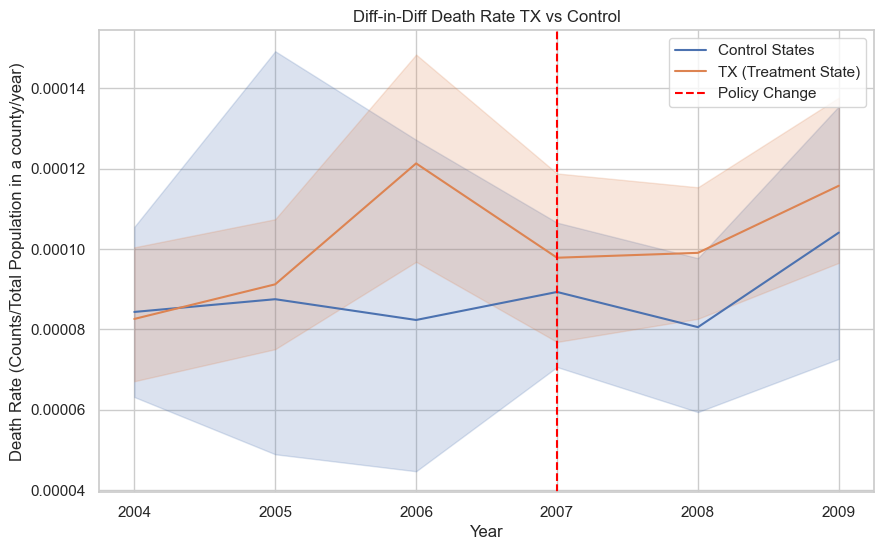

In [ ]:
sns.set(style="whitegrid")

df_control12 = tx_diff_diff[tx_diff_diff["Treated"] == 0]
df_treatment12 = tx_diff_diff[tx_diff_diff["Treated"] == 1]
# Plot the trends
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="DeathRate", data=df_control12, label="Control States")
sns.lineplot(x="Year", y="DeathRate", data=df_treatment12, label="TX (Treatment State)")
plt.axvline(x=2007, color="red", linestyle="--", label="Policy Change")
plt.title("Diff-in-Diff Death Rate TX vs Control")

plt.xlabel("Year")
plt.ylabel("Death Rate (Counts/Total Population in a county/year)")
plt.legend()